In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import bbknn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import pymn
import itertools

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg/pymn/trainModel.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg/pymn/trainModel.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [2]:

maize_single_cell = sc.read_h5ad('/data/passala/Collaborator_Data/Maize_arabi_Jack_Collab/xu16_19_29_32_SeuratV4.0.1_finalclustermaize.h5ad')
maize_single_cell #Test annotation for my data

AnnData object with n_obs × n_vars = 10551 × 28492
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DataSet', 'integrated_snn_res.1', 'seurat_clusters', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1'
    var: 'features'
    obsm: 'X_umap'

In [3]:
maize_single_cell.obsm['X_umap']

array([[-1.24868038,  2.23365191],
       [-4.71031561,  1.73476366],
       [ 1.41274533,  1.85823373],
       ...,
       [-3.27618447,  2.46618585],
       [-3.75875845,  1.31210891],
       [-5.12317315, -1.43737992]])

In [4]:
arabi_single_cell = sc.read_h5ad('/data/passala/Collaborator_Data/Maize_arabi_Jack_Collab/xu_41_42.int_filter_recluster_final_forBen_arabi.h5ad')
arabi_single_cell

AnnData object with n_obs × n_vars = 20224 × 23339
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54'
    var: 'features'
    obsm: 'X_umap'

In [5]:
co_expressalog_map_85 = pd.read_csv('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/Minor_tables/true_pair_dataframe_at_80_tolerance.csv')
ensmbl_to_grm = pd.read_csv('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/Minor_tables/ensmbl_to_grm_table.csv')
co_expressalog_map_85

Arabidopsis Gene      Maize Gene
0           AT3G50620  Zm00001d029417
1           AT2G15730  Zm00001d052886
2           AT5G44040  Zm00001d027589
3           AT5G42760  Zm00001d034249
4           AT3G53470  Zm00001d031954
...               ...             ...
6230        AT2G35170  Zm00001d000053
6231        AT4G17540  Zm00001d000035
6232        AT4G16970  Zm00001d000034
6233        AT2G15980  Zm00001d000435
6234        AT5G51150  Zm00001d000436

[6235 rows x 2 columns]

In [6]:
co_expressalog_map_85 = co_expressalog_map_85.merge(right = ensmbl_to_grm, how = 'left', left_on= 'Maize Gene', right_on= 'EnsemblID')
co_expressalog_map_85 = co_expressalog_map_85.dropna()
co_expressalog_map_85 = co_expressalog_map_85[['Arabidopsis Gene','GRM Name']]


In [7]:
co_expressalog_map_85

Arabidopsis Gene       GRM Name
0           AT3G50620  GRMZM2G003530
1           AT2G15730  GRMZM5G877077
2           AT5G44040  GRMZM2G172758
3           AT5G42760  GRMZM2G068179
4           AT3G53470  GRMZM2G144982
...               ...            ...
6225        AT4G18370  GRMZM2G118646
6227        AT1G77840           EIF5
6228        AT1G71696  GRMZM2G106683
6229        AT4G27030  GRMZM2G175401
6231        AT4G17540  GRMZM2G040991

[5329 rows x 2 columns]

In [8]:
co_expressalog_map_85.to_csv('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/Minor_tables/coexpressalog_at_80_tolerance_v3_names.csv')

In [9]:
arabi_single_cell.var.index

Index(['AT1G01010', 'AT1G01020', 'AT1G01030', 'AT1G01040', 'AT1G01050',
       'AT1G03997', 'AT1G01060', 'AT1G01070', 'AT1G01080', 'AT1G01090',
       ...
       'AT5G09475', 'AT5G65800', 'AT5G66390', 'AT5G09665', 'AT5G09775',
       'AT5G67060', 'ATCG00830', 'ATCG00920', 'ATCG01000', 'ATMG00560'],
      dtype='object', length=23339)

In [10]:
arabi_single_cell.var = arabi_single_cell.var.merge(right = co_expressalog_map_85, right_on = 'Arabidopsis Gene', how = 'left', left_on = 'features')

arabi_single_cell.var.index = arabi_single_cell.var['features'].to_list()
arabi_single_cell.var

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


features Arabidopsis Gene       GRM Name
AT1G01010  AT1G01010              NaN            NaN
AT1G01020  AT1G01020              NaN            NaN
AT1G01030  AT1G01030              NaN            NaN
AT1G01040  AT1G01040              NaN            NaN
AT1G01050  AT1G01050        AT1G01050  GRMZM2G061928
...              ...              ...            ...
AT5G67060  AT5G67060              NaN            NaN
ATCG00830  ATCG00830              NaN            NaN
ATCG00920  ATCG00920              NaN            NaN
ATCG01000  ATCG01000              NaN            NaN
ATMG00560  ATMG00560              NaN            NaN

[23339 rows x 3 columns]

In [11]:
maize_single_cell.var

features
GRMZM2G059865  GRMZM2G059865
GRMZM2G093344  GRMZM2G093344
GRMZM2G306216  GRMZM2G306216
GRMZM2G104572  GRMZM2G104572
GRMZM5G822187  GRMZM5G822187
...                      ...
GRMZM2G128549  GRMZM2G128549
GRMZM2G450231  GRMZM2G450231
GRMZM2G074773  GRMZM2G074773
GRMZM5G826672  GRMZM5G826672
GRMZM5G893089  GRMZM5G893089

[28492 rows x 1 columns]

In [12]:
co_expressalog_map_85

Arabidopsis Gene       GRM Name
0           AT3G50620  GRMZM2G003530
1           AT2G15730  GRMZM5G877077
2           AT5G44040  GRMZM2G172758
3           AT5G42760  GRMZM2G068179
4           AT3G53470  GRMZM2G144982
...               ...            ...
6225        AT4G18370  GRMZM2G118646
6227        AT1G77840           EIF5
6228        AT1G71696  GRMZM2G106683
6229        AT4G27030  GRMZM2G175401
6231        AT4G17540  GRMZM2G040991

[5329 rows x 2 columns]

In [13]:
maize_single_cell.var

features
GRMZM2G059865  GRMZM2G059865
GRMZM2G093344  GRMZM2G093344
GRMZM2G306216  GRMZM2G306216
GRMZM2G104572  GRMZM2G104572
GRMZM5G822187  GRMZM5G822187
...                      ...
GRMZM2G128549  GRMZM2G128549
GRMZM2G450231  GRMZM2G450231
GRMZM2G074773  GRMZM2G074773
GRMZM5G826672  GRMZM5G826672
GRMZM5G893089  GRMZM5G893089

[28492 rows x 1 columns]

In [14]:
maize_single_cell.var.merge(right = co_expressalog_map_85, right_on = 'GRM Name', how = 'left', left_on = 'features')


features Arabidopsis Gene GRM Name
0      GRMZM2G059865              NaN      NaN
1      GRMZM2G093344              NaN      NaN
2      GRMZM2G306216              NaN      NaN
3      GRMZM2G104572              NaN      NaN
4      GRMZM5G822187              NaN      NaN
...              ...              ...      ...
28487  GRMZM2G128549              NaN      NaN
28488  GRMZM2G450231              NaN      NaN
28489  GRMZM2G074773              NaN      NaN
28490  GRMZM5G826672              NaN      NaN
28491  GRMZM5G893089              NaN      NaN

[28492 rows x 3 columns]

In [15]:
maize_single_cell.var = maize_single_cell.var.merge(right = co_expressalog_map_85, right_on = 'GRM Name', how = 'left', left_on = 'features')

maize_single_cell.var.index = maize_single_cell.var['features'].to_list()
maize_single_cell.var

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


features Arabidopsis Gene GRM Name
GRMZM2G059865  GRMZM2G059865              NaN      NaN
GRMZM2G093344  GRMZM2G093344              NaN      NaN
GRMZM2G306216  GRMZM2G306216              NaN      NaN
GRMZM2G104572  GRMZM2G104572              NaN      NaN
GRMZM5G822187  GRMZM5G822187              NaN      NaN
...                      ...              ...      ...
GRMZM2G128549  GRMZM2G128549              NaN      NaN
GRMZM2G450231  GRMZM2G450231              NaN      NaN
GRMZM2G074773  GRMZM2G074773              NaN      NaN
GRMZM5G826672  GRMZM5G826672              NaN      NaN
GRMZM5G893089  GRMZM5G893089              NaN      NaN

[28492 rows x 3 columns]

In [16]:
arabi_var_names_with_ortholog = arabi_single_cell.var.dropna().index
arabi_version_of_maize_genes_with_ortholog = maize_single_cell.var.dropna()['Arabidopsis Gene'].to_list()

In [17]:
overlap_of_shared_genes = arabi_var_names_with_ortholog.intersection(arabi_version_of_maize_genes_with_ortholog)
overlap_of_shared_genes

Index(['AT1G01090', 'AT1G01140', 'AT1G01210', 'AT1G01225', 'AT1G01350',
       'AT1G01360', 'AT1G01370', 'AT1G01470', 'AT1G01490', 'AT1G01500',
       ...
       'AT5G67440', 'AT5G67500', 'AT5G67530', 'AT5G67540', 'AT5G67590',
       'AT1G44608', 'AT2G18360', 'AT2G20825', 'AT2G30424', 'AT4G19645'],
      dtype='object', length=4903)

In [18]:
maize_genes_to_keep = maize_single_cell.var.loc[maize_single_cell.var['Arabidopsis Gene'].isin(overlap_of_shared_genes)].index

In [19]:
maize_single_cell_trimmed_to_orthologs = maize_single_cell[:,maize_genes_to_keep]
maize_single_cell_trimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 10551 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DataSet', 'integrated_snn_res.1', 'seurat_clusters', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1'
    var: 'features', 'Arabidopsis Gene', 'GRM Name'
    obsm: 'X_umap'

In [20]:
arabi_single_cell_slimmed_to_orthologs = arabi_single_cell[:,overlap_of_shared_genes]
arabi_single_cell_slimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 20224 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54'
    var: 'features', 'Arabidopsis Gene', 'GRM Name'
    obsm: 'X_umap'

In [21]:
maize_single_cell_trimmed_to_orthologs.var.index = maize_single_cell_trimmed_to_orthologs.var['Arabidopsis Gene'].to_list()
maize_single_cell_trimmed_to_orthologs.var

features Arabidopsis Gene       GRM Name
AT3G60340  GRMZM2G374779        AT3G60340  GRMZM2G374779
AT5G61520  GRMZM2G374812        AT5G61520  GRMZM2G374812
AT5G61510  GRMZM2G002121        AT5G61510  GRMZM2G002121
AT4G30600  GRMZM2G060296        AT4G30600  GRMZM2G060296
AT4G11450  GRMZM2G703466        AT4G11450  GRMZM2G703466
...                  ...              ...            ...
AT1G65032  GRMZM2G431885        AT1G65032  GRMZM2G431885
AT3G50400  GRMZM2G070178        AT3G50400  GRMZM2G070178
AT5G49810  GRMZM2G098031        AT5G49810  GRMZM2G098031
AT2G18660  GRMZM2G099092        AT2G18660  GRMZM2G099092
AT1G61520  GRMZM2G010884        AT1G61520  GRMZM2G010884

[4903 rows x 3 columns]

In [22]:
order_of_vars = arabi_single_cell_slimmed_to_orthologs.var.index.to_list()
current_order_maize_vars = maize_single_cell_trimmed_to_orthologs.var_names
panda_version_of_maize_x_data = pd.DataFrame(columns = current_order_maize_vars, data = maize_single_cell_trimmed_to_orthologs.X.todense())

re_ordered_version = panda_version_of_maize_x_data.reindex(columns = order_of_vars)
re_ordered_version = sparse.csr_matrix(re_ordered_version.values)
maize_single_cell_trimmed_to_orthologs.X = re_ordered_version
maize_single_cell_trimmed_to_orthologs.var = maize_single_cell_trimmed_to_orthologs.var.reindex(order_of_vars)

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [23]:
# maize_single_cell_trimmed_to_orthologs.obs['Species'] = 'Maize'
# arabi_single_cell_slimmed_to_orthologs.obs['Species'] = 'Arabidopsis'


In [24]:
sc.pp.highly_variable_genes(maize_single_cell_trimmed_to_orthologs, min_mean=0.01, max_mean=4, min_disp=0.1)


In [25]:
maize_single_cell_trimmed_to_orthologs.var

features Arabidopsis Gene       GRM Name  highly_variable  \
AT1G01090  GRMZM2G033894        AT1G01090  GRMZM2G033894            False   
AT1G01140  GRMZM2G055575        AT1G01140  GRMZM2G055575             True   
AT1G01210  GRMZM2G138407        AT1G01210  GRMZM2G138407            False   
AT1G01225  GRMZM2G124802        AT1G01225  GRMZM2G124802             True   
AT1G01350  GRMZM2G164359        AT1G01350  GRMZM2G164359            False   
...                  ...              ...            ...              ...   
AT1G44608  GRMZM5G817182        AT1G44608  GRMZM5G817182            False   
AT2G18360  GRMZM2G037322        AT2G18360  GRMZM2G037322            False   
AT2G20825  GRMZM2G082745        AT2G20825  GRMZM2G082745             True   
AT2G30424  GRMZM2G057955        AT2G30424  GRMZM2G057955            False   
AT4G19645  GRMZM5G825226        AT4G19645  GRMZM5G825226            False   

              means  dispersions  dispersions_norm  
AT1G01090  0.614909    -0.208041         -0.701834  
AT1G01140  0.095496    -0.071213          0.510060  
AT1G01210  0.294653    -0.211556         -0.347140  
AT1G01225  0.017622    -0.121474          0.315016  
AT1G01350  0.265670    -0.352836         -0.791466  
...             ...          ...               ...  
AT1G44608  0.007616    -0.043106          0.619132  
AT2G18360  0.002016    -0.301945         -0.385313  
AT2G20825  0.185918     0.119466          0.693933  
AT2G30424  0.000892    -0.323183         -0.467732  
AT4G19645  0.044245    -0.254022         -0.199346  

[4903 rows x 7 columns]

In [26]:
maize_single_cell_trimmed_to_orthologs.var.sum()

features            GRMZM2G033894GRMZM2G055575GRMZM2G138407GRMZM2G...
Arabidopsis Gene    AT1G01090AT1G01140AT1G01210AT1G01225AT1G01350A...
GRM Name            GRMZM2G033894GRMZM2G055575GRMZM2G138407GRMZM2G...
highly_variable                                                  1267
means                                                      1212.77057
dispersions                                               -464.768218
dispersions_norm                                             0.999996
dtype: object

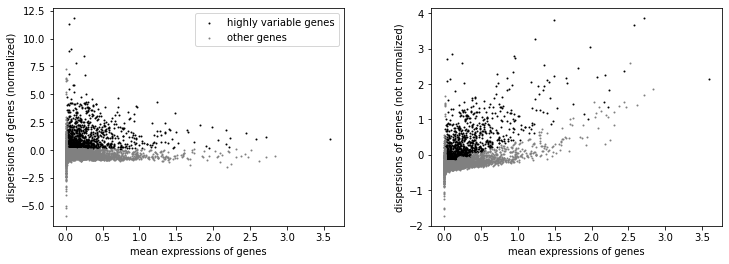

In [27]:
sc.pl.highly_variable_genes(maize_single_cell_trimmed_to_orthologs)


In [28]:
sc.pp.pca(maize_single_cell_trimmed_to_orthologs)
sc.pp.neighbors(maize_single_cell_trimmed_to_orthologs)
sc.tl.umap(maize_single_cell_trimmed_to_orthologs, random_state=20)

In [29]:
sc.set_figure_params(facecolor = 'white', figsize = (15,15))

In [30]:
sc.tl.leiden(maize_single_cell_trimmed_to_orthologs)

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'DataSet' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in

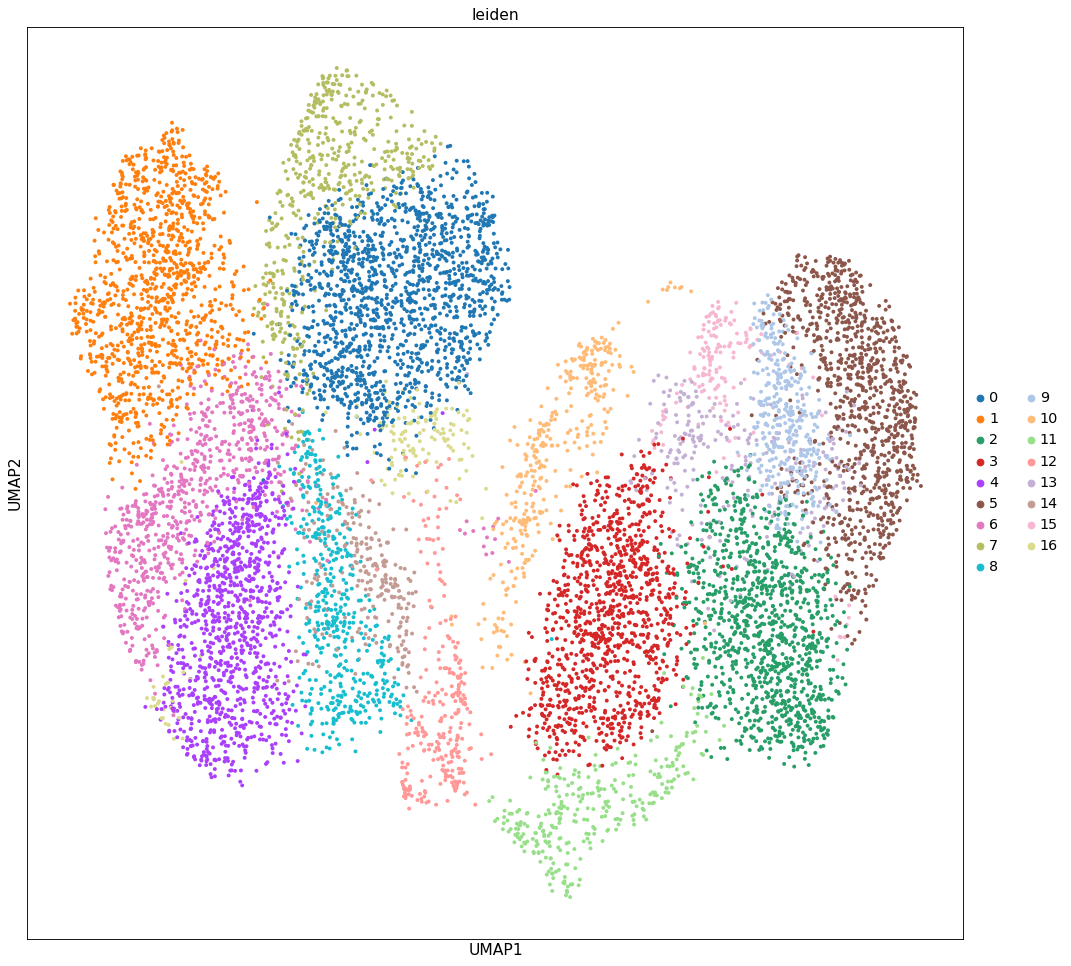

In [31]:
sc.pl.umap(maize_single_cell_trimmed_to_orthologs, color= 'leiden', s = 50)

In [32]:
maize_single_cell_trimmed_to_orthologs.var.loc[maize_single_cell_trimmed_to_orthologs.var['features']== 'KN-1']

Empty DataFrame
Columns: [features, Arabidopsis Gene, GRM Name, highly_variable, means, dispersions, dispersions_norm]
Index: []

In [33]:
maize_single_cell.obs['leiden'] = maize_single_cell_trimmed_to_orthologs.obs['leiden']

In [34]:
maize_single_cell.var.loc['GRMZM2G372364']

features            GRMZM2G372364
Arabidopsis Gene              NaN
GRM Name                      NaN
Name: GRMZM2G372364, dtype: object

In [35]:
maize_single_cell.obsm['X_umap']

array([[-1.24868038,  2.23365191],
       [-4.71031561,  1.73476366],
       [ 1.41274533,  1.85823373],
       ...,
       [-3.27618447,  2.46618585],
       [-3.75875845,  1.31210891],
       [-5.12317315, -1.43737992]])

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'DataSet' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in

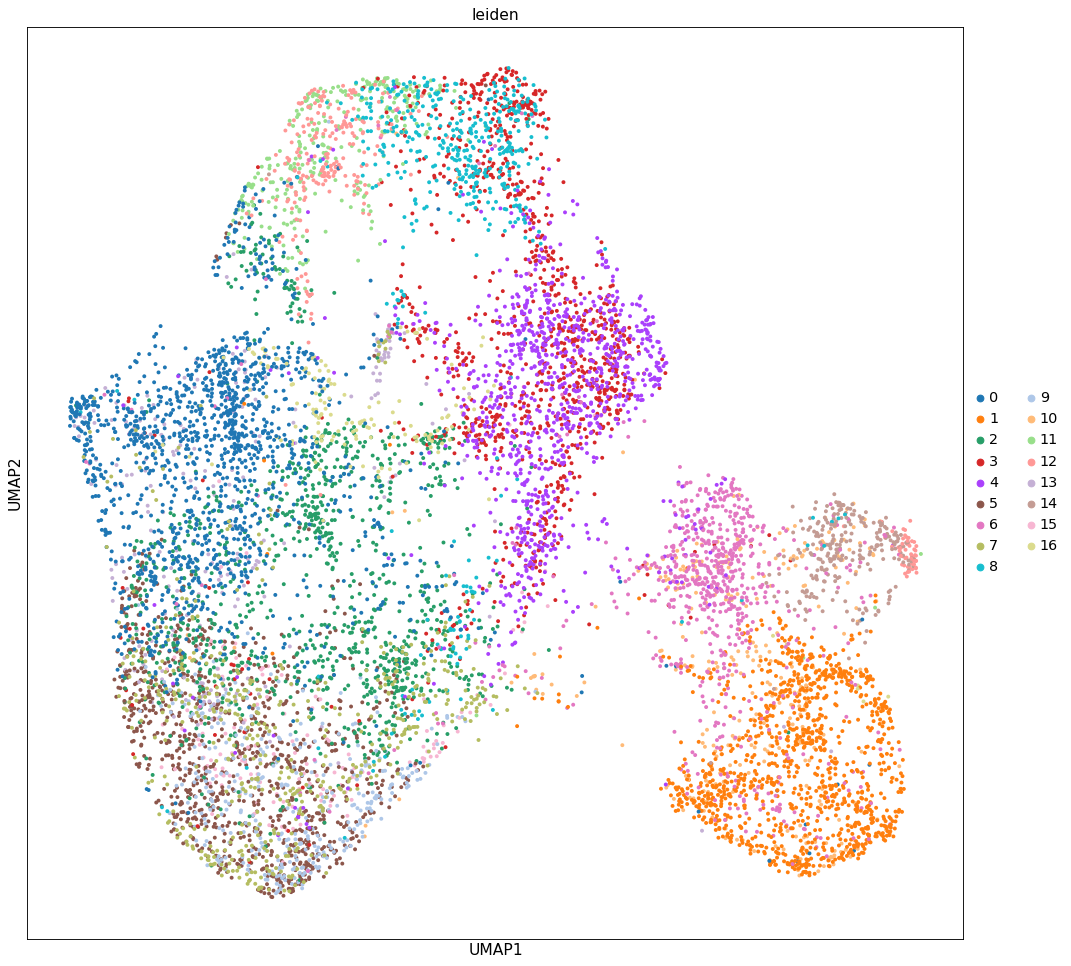

In [36]:
sc.pl.umap(maize_single_cell, color= 'leiden', s = 50)

In [37]:
maize_single_cell.var.loc['KN-1']

features            KN-1
Arabidopsis Gene     NaN
GRM Name             NaN
Name: KN-1, dtype: object

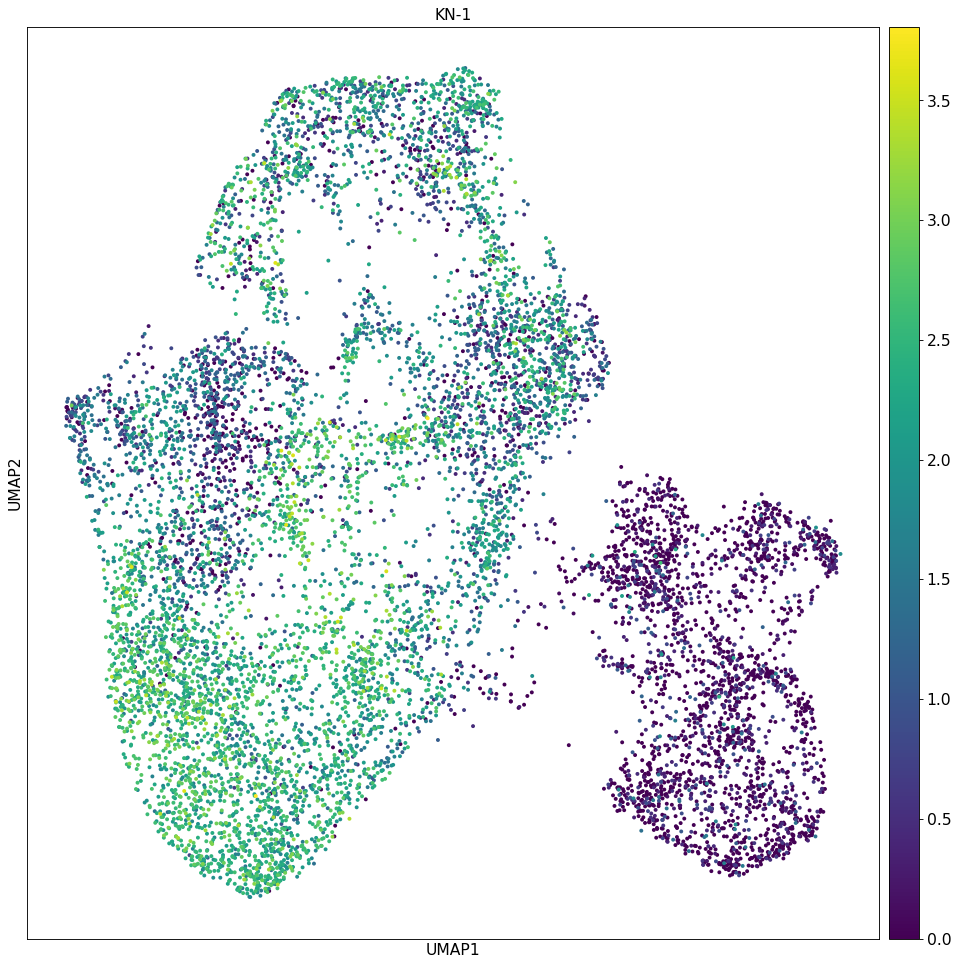

In [38]:
sc.pl.umap(maize_single_cell, color= ['KN-1'], s = 50, use_raw=False)

In [39]:
sc.tl.ingest(arabi_single_cell_slimmed_to_orthologs,maize_single_cell_trimmed_to_orthologs, obs = 'leiden')
arabi_single_cell_slimmed_to_orthologs.uns['leiden_colors'] = maize_single_cell_trimmed_to_orthologs.uns['leiden_colors']  # fix colors


In [40]:
arabi_single_cell_slimmed_to_orthologs.uns

OverloadedDict, wrapping:
	OrderedDict([('leiden_colors', ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d'])])
With overloaded keys:
	['neighbors'].

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'RNA_snn_res.0.5' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` para

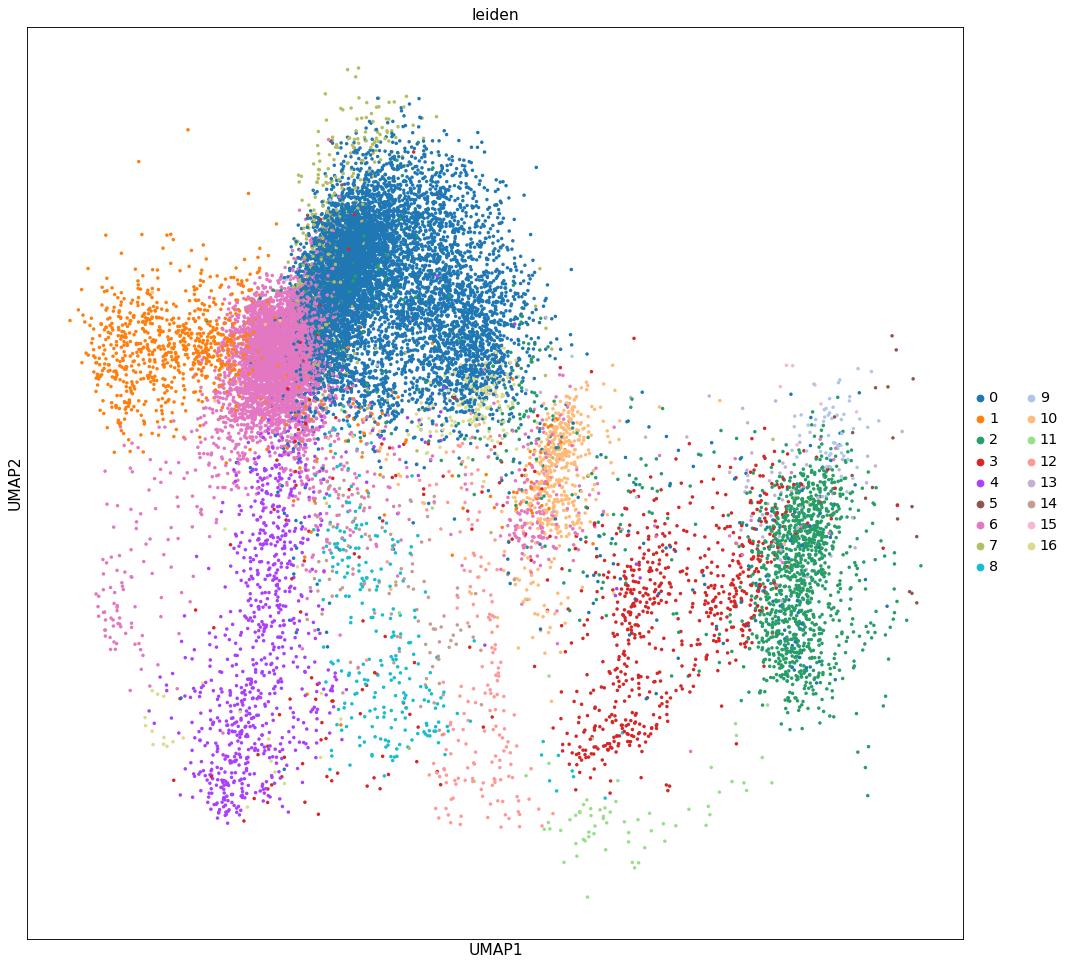

In [41]:
sc.pl.umap(arabi_single_cell_slimmed_to_orthologs, color='leiden', wspace=0.5, s = 40)


In [42]:
arabi_single_cell_slimmed_to_orthologs.var.loc['AT2G42840']

KeyError: 'AT2G42840'

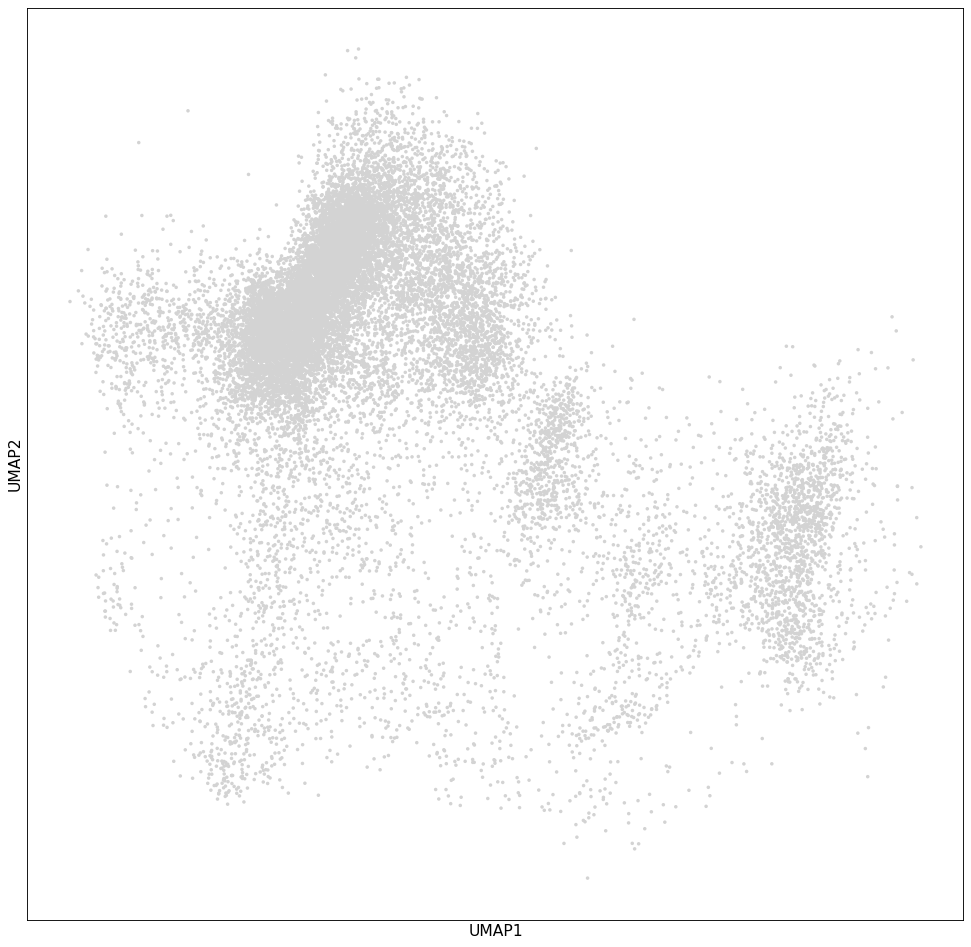

In [43]:
sc.pl.umap(arabi_single_cell_slimmed_to_orthologs, wspace=0.5, s = 40)


In [44]:
concatendated_arabi_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(arabi_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Arabidopsis'])

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical


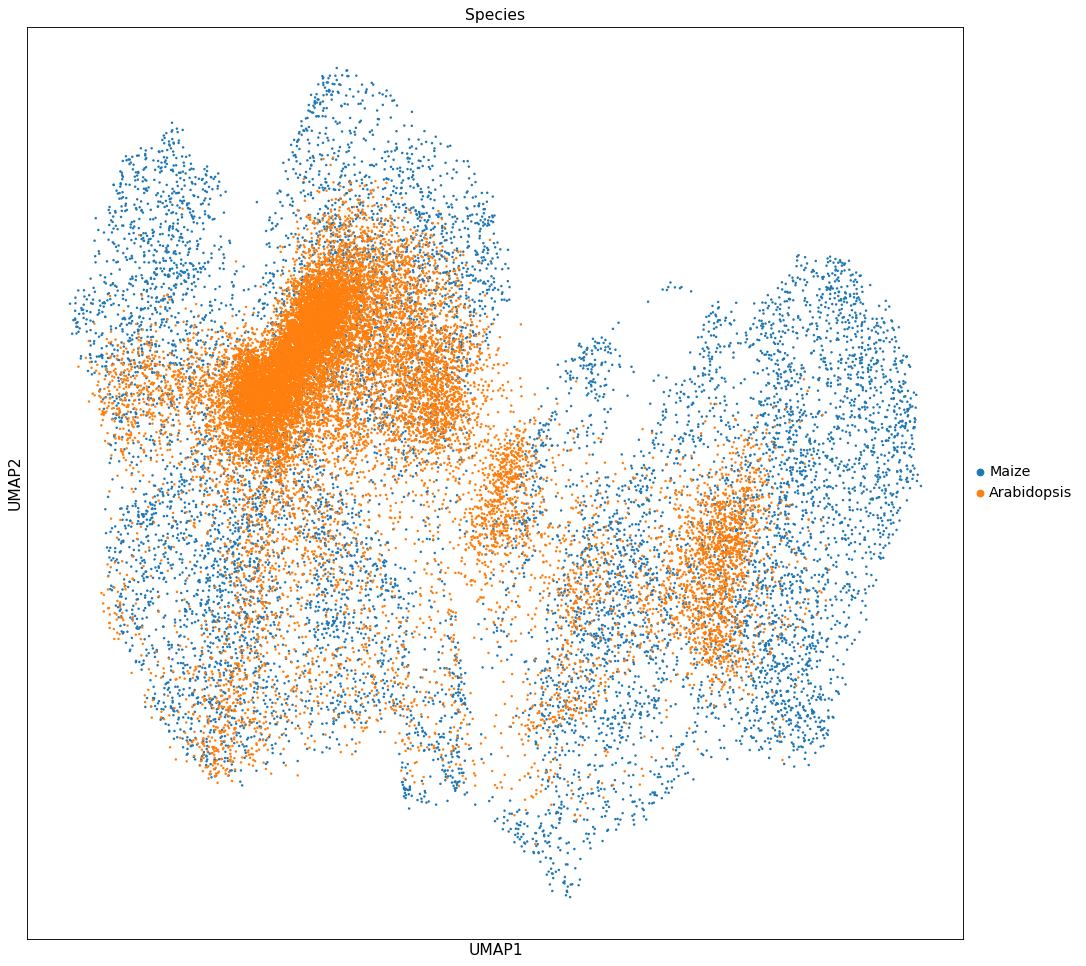

In [45]:
sc.pl.umap(concatendated_arabi_maize_dataset, color='Species', s= 20, palette =['tab:blue','tab:orange'])


In [46]:
concatendated_arabi_maize_dataset.obs.leiden = concatendated_arabi_maize_dataset.obs.leiden.astype('category')
concatendated_arabi_maize_dataset.obs.leiden.cat.reorder_categories(maize_single_cell_trimmed_to_orthologs.obs.leiden.cat.categories, inplace=True)  # fix category ordering
concatendated_arabi_maize_dataset.uns['leiden_colors'] = maize_single_cell_trimmed_to_orthologs.uns['leiden_colors']  # fix category colors




/tmp/ipykernel_2784269/1481419399.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  concatendated_arabi_maize_dataset.obs.leiden.cat.reorder_categories(maize_single_cell_trimmed_to_orthologs.obs.leiden.cat.categories, inplace=True)  # fix category ordering


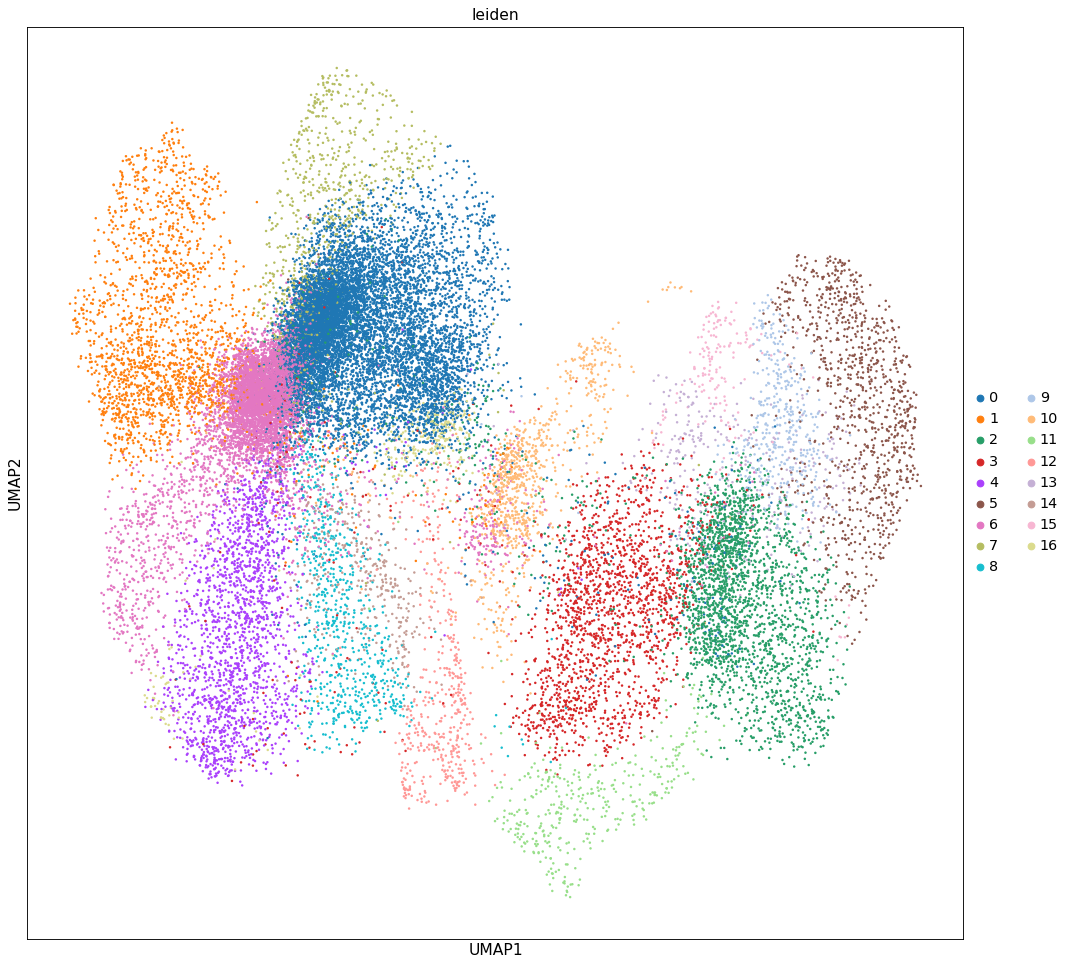

In [47]:
sc.pl.umap(concatendated_arabi_maize_dataset, color='leiden', s= 20)


In [48]:
concatendated_arabi_maize_dataset.var['Gene'] = concatendated_arabi_maize_dataset.var_names
concatendated_arabi_maize_dataset.obs['CellID'] = concatendated_arabi_maize_dataset.obs_names

In [49]:
concatendated_arabi_maize_dataset

AnnData object with n_obs × n_vars = 30775 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DataSet', 'integrated_snn_res.1', 'seurat_clusters', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1', 'leiden', 'percent.mt', 'RNA_snn_res.0.5', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54', 'Species', 'CellID'
    var: 'Arabidopsis Gene', 'GRM Name', 'features-Arabidopsis', 'features-Maize', 'highly_variable-Maize', 'means-Maize', 'dispersions-Maize', 'dispersions_norm-Maize', 'Gene'
    uns: 'Species_colors', 'leiden_colors'
    obsm: 'X_umap', 'X_pca'

In [50]:
concatendated_arabi_maize_dataset.obs = concatendated_arabi_maize_dataset.obs[['nCount_RNA','seurat_clusters','nFeature_RNA','leiden','Species','DataSet','subcluster9']]

In [51]:
concatendated_arabi_maize_dataset.raw = concatendated_arabi_maize_dataset

In [52]:
concatendated_arabi_maize_dataset.raw.X

<30775x4903 sparse matrix of type '<class 'numpy.float32'>'
	with 41646558 stored elements in Compressed Sparse Row format>

In [53]:
concatendated_arabi_maize_dataset.write('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/loom_files_for_jack/combined_arabidop_maize_as_h5ad_version_with_seurat.h5ad')

In [54]:
arabi_single_cell

AnnData object with n_obs × n_vars = 20224 × 23339
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54'
    var: 'features', 'Arabidopsis Gene', 'GRM Name'
    obsm: 'X_umap'

In [55]:
# arabi_single_cell.var['Gene'] = arabi_single_cell.var_names
# arabi_single_cell.obs['CellID'] = arabi_single_cell.obs_names

In [56]:
arabi_single_cell.uns['leiden_colors'] = arabi_single_cell_slimmed_to_orthologs.uns['leiden_colors']
arabi_single_cell.obs['leiden'] = arabi_single_cell_slimmed_to_orthologs.obs['leiden']


In [57]:
arabi_single_cell.obs = arabi_single_cell.obs[['nCount_RNA','seurat_clusters','nFeature_RNA','leiden']]

In [58]:
arabi_single_cell.raw = arabi_single_cell

In [59]:
#arabi_single_cell.write('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/loom_files_for_jack/just_arabidopsis_single_cell_with_leiden_and_seurat_clusters.h5ad')


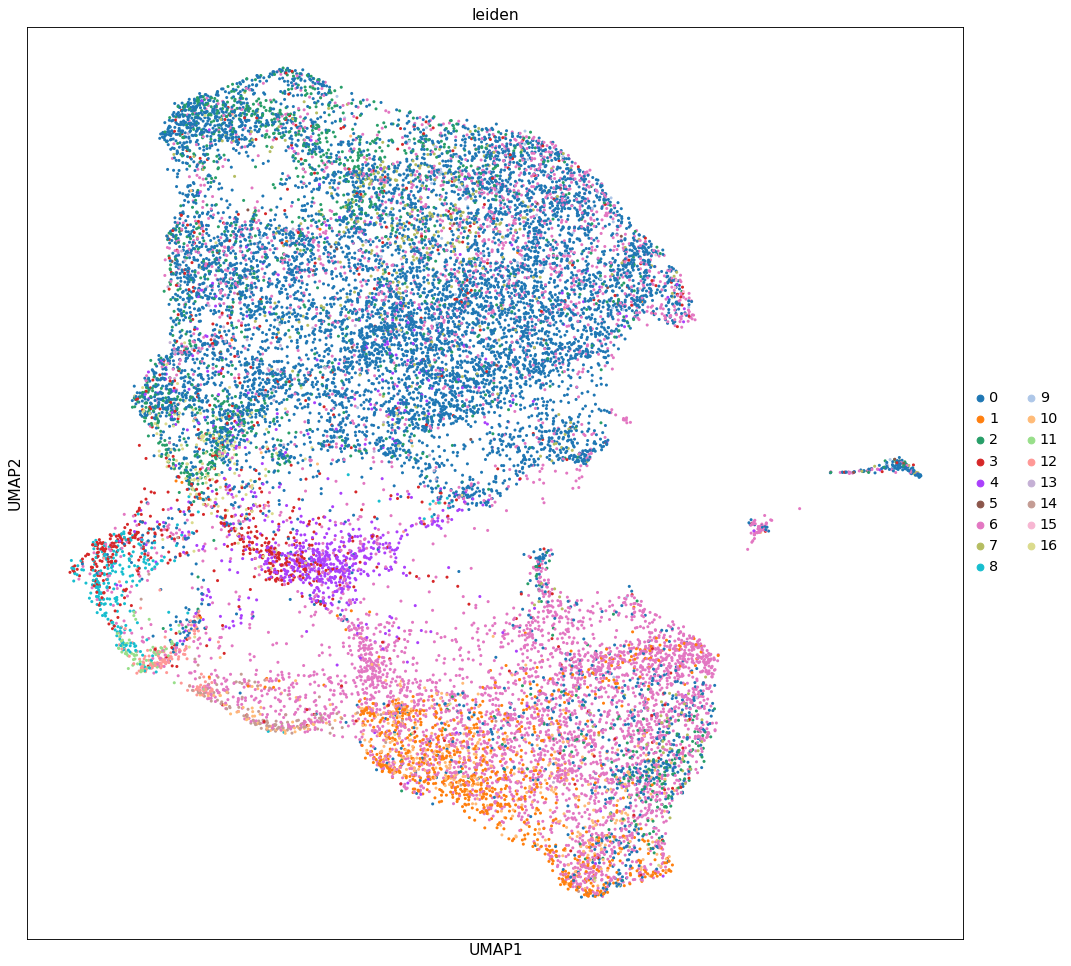

In [82]:
sc.pl.umap(arabi_single_cell, color='leiden', s= 30, save = 'arab_back_map.png')


In [61]:
maize_single_cell

AnnData object with n_obs × n_vars = 10551 × 28492
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DataSet', 'integrated_snn_res.1', 'seurat_clusters', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1', 'leiden'
    var: 'features', 'Arabidopsis Gene', 'GRM Name'
    uns: 'leiden_colors'
    obsm: 'X_umap'

In [62]:
maize_single_cell.obs = maize_single_cell.obs[['nCount_RNA','seurat_clusters','nFeature_RNA','leiden','DataSet','subcluster9']]

In [63]:
maize_single_cell.raw = maize_single_cell

In [64]:
maize_single_cell.write('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/loom_files_for_jack/just_maize_single_cell_with_leiden_and_seurat_clusters.h5ad')


/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


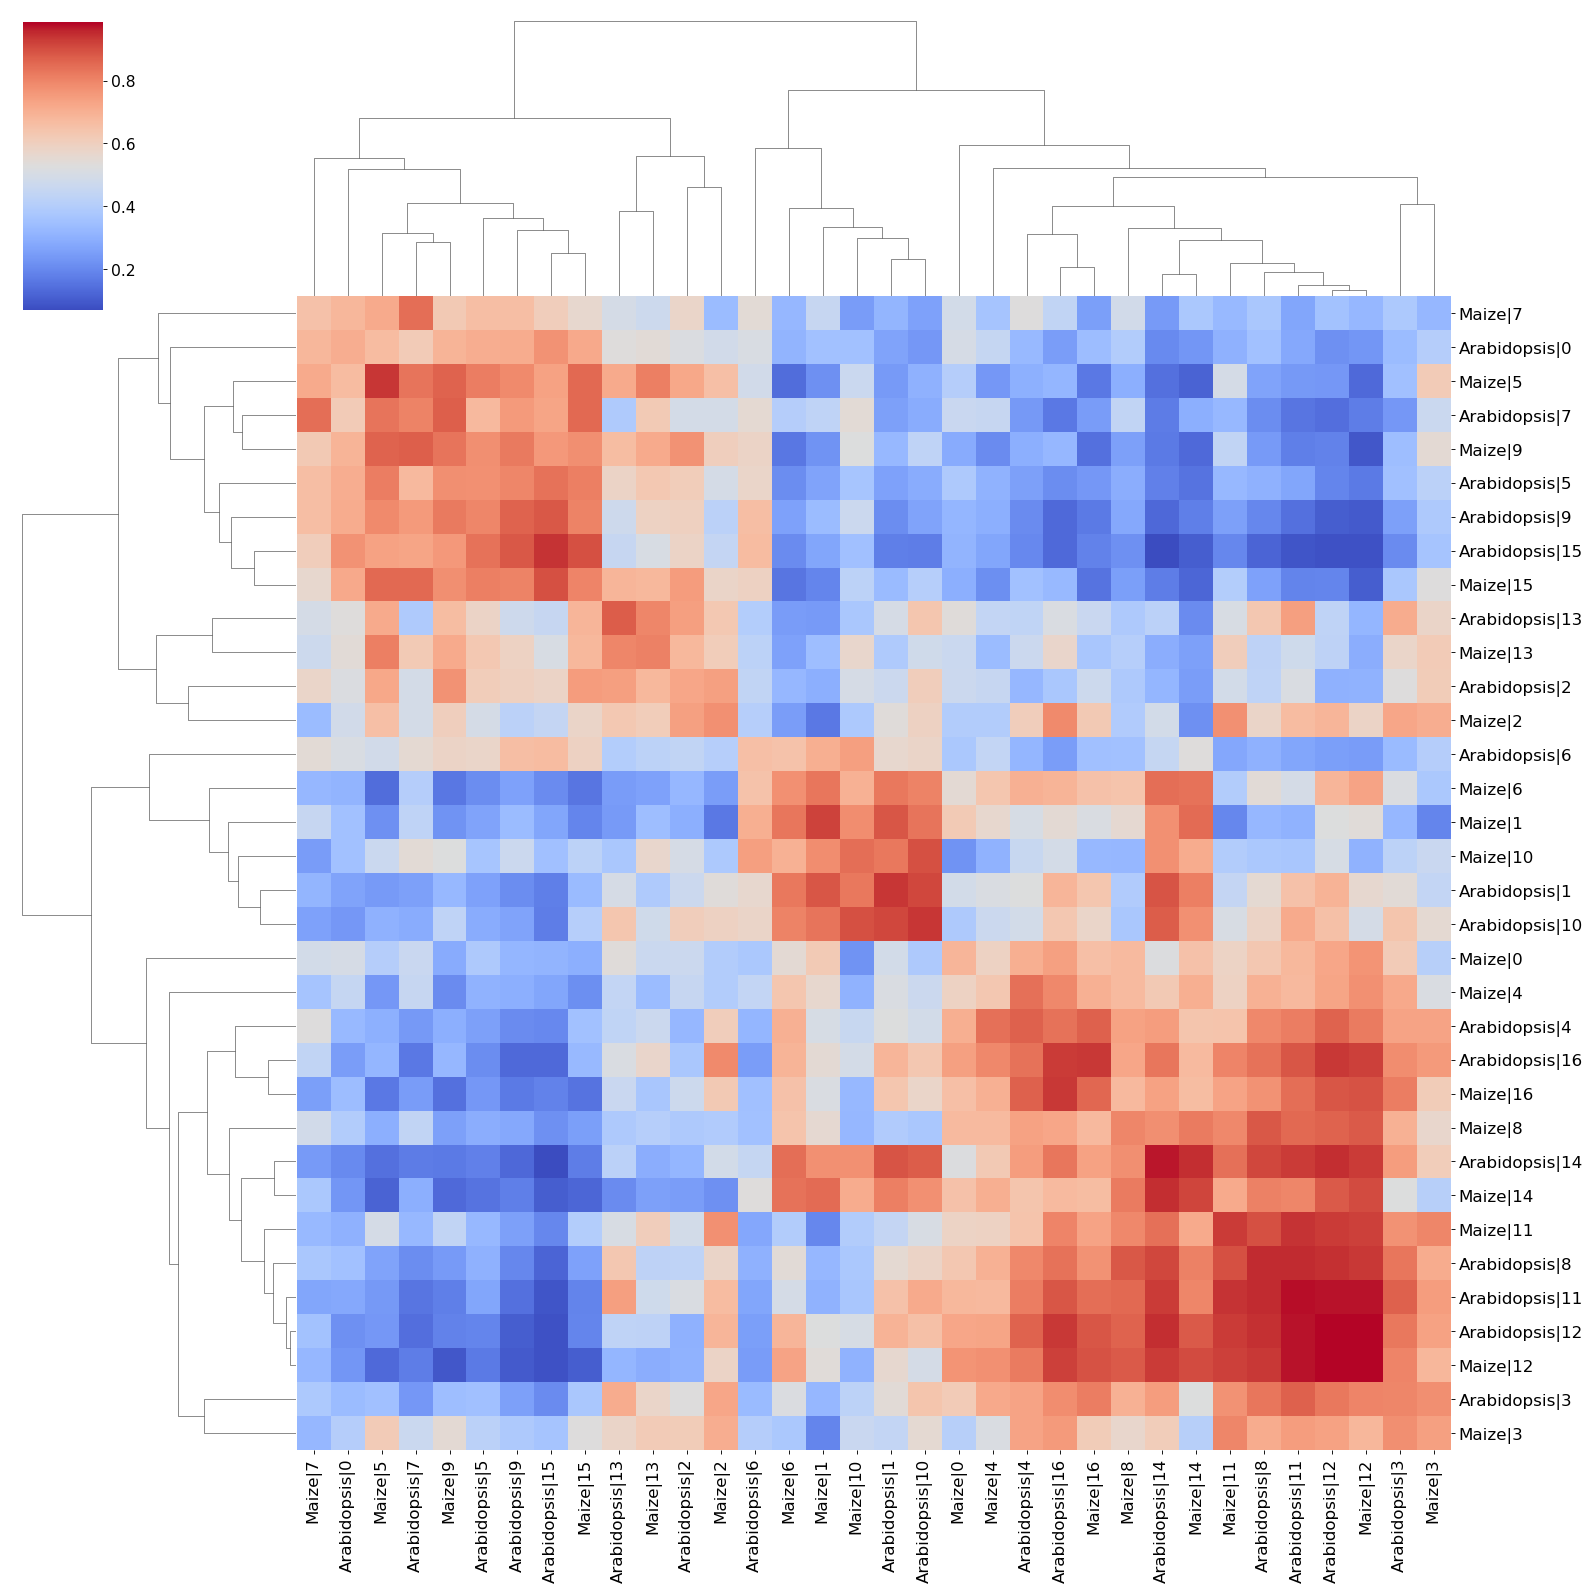

In [65]:
pymn.variableGenes(concatendated_arabi_maize_dataset,study_col = 'Species')
pymn.MetaNeighborUS(concatendated_arabi_maize_dataset,study_col = 'Species',ct_col = 'leiden')
pymn.plotMetaNeighborUS(concatendated_arabi_maize_dataset,figsize = (20,20),cmap = 'coolwarm',fontsize = 15)

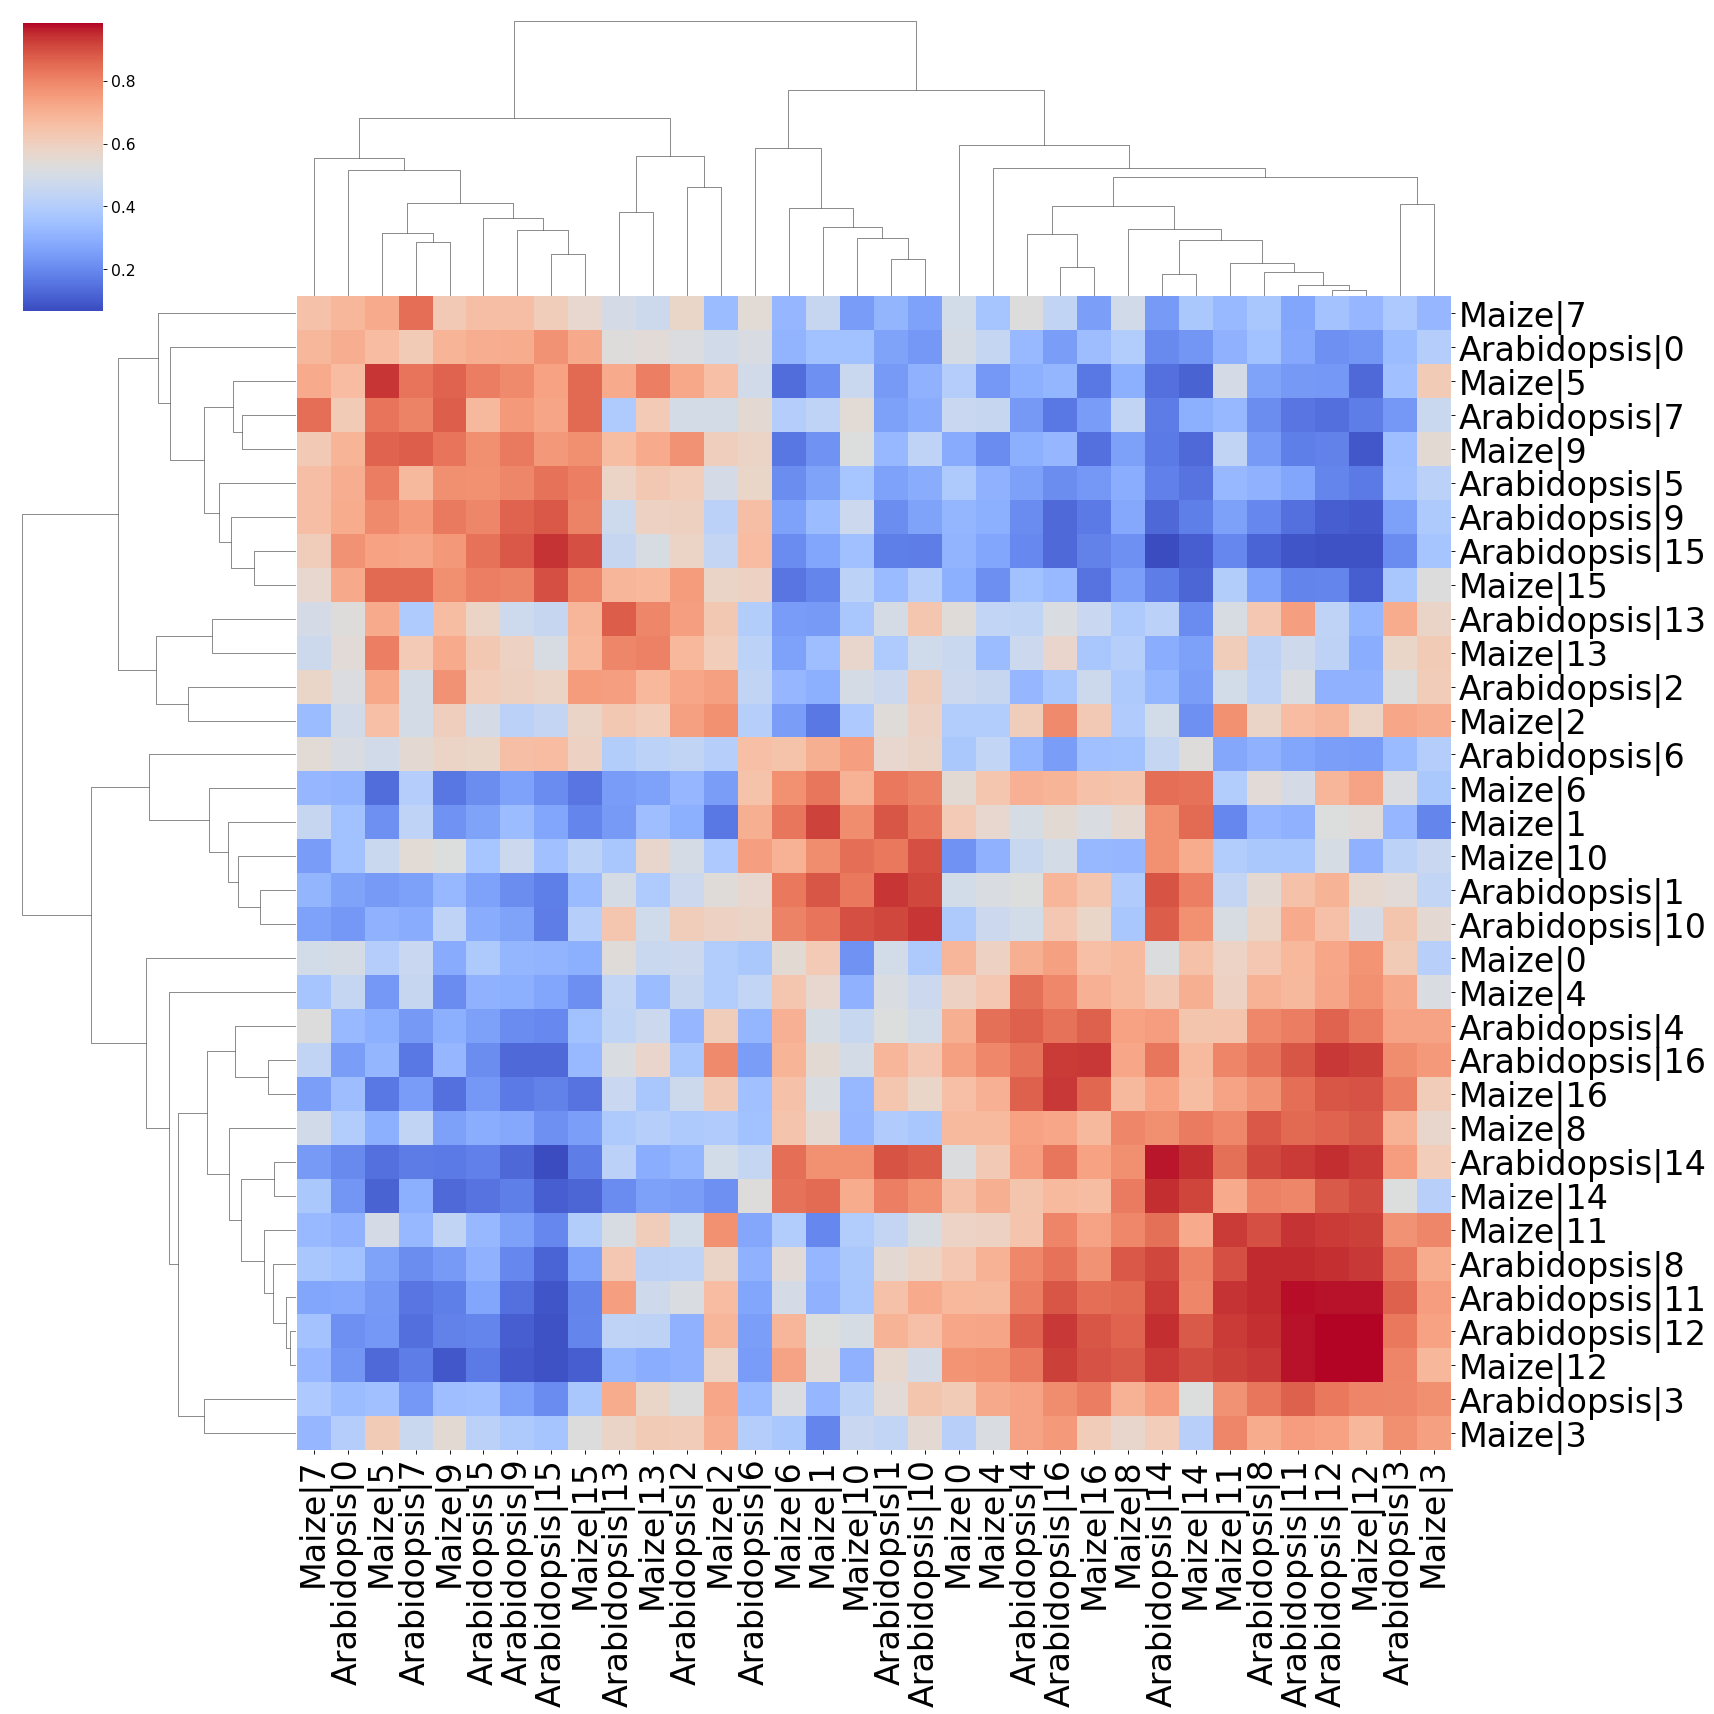

In [66]:
pymn.plotMetaNeighborUS(concatendated_arabi_maize_dataset,figsize = (20,20),cmap = 'coolwarm',fontsize = 30)

In [67]:
list_of_leiden_groups = np.arange(0,15,1)

In [68]:
list_of_leiden_columns = []
for species in ['Maize','Arabidopsis']:
    for group in list_of_leiden_groups:
        current_group = f'{species} Cluster {group}'
        list_of_leiden_columns.append(current_group)
        

In [69]:
list_of_leiden_columns

['Maize Cluster 0',
 'Maize Cluster 1',
 'Maize Cluster 2',
 'Maize Cluster 3',
 'Maize Cluster 4',
 'Maize Cluster 5',
 'Maize Cluster 6',
 'Maize Cluster 7',
 'Maize Cluster 8',
 'Maize Cluster 9',
 'Maize Cluster 10',
 'Maize Cluster 11',
 'Maize Cluster 12',
 'Maize Cluster 13',
 'Maize Cluster 14',
 'Arabidopsis Cluster 0',
 'Arabidopsis Cluster 1',
 'Arabidopsis Cluster 2',
 'Arabidopsis Cluster 3',
 'Arabidopsis Cluster 4',
 'Arabidopsis Cluster 5',
 'Arabidopsis Cluster 6',
 'Arabidopsis Cluster 7',
 'Arabidopsis Cluster 8',
 'Arabidopsis Cluster 9',
 'Arabidopsis Cluster 10',
 'Arabidopsis Cluster 11',
 'Arabidopsis Cluster 12',
 'Arabidopsis Cluster 13',
 'Arabidopsis Cluster 14']

In [70]:
data_frame_of_centroid_results = pd.DataFrame(index = concatendated_arabi_maize_dataset.var_names, columns = list_of_leiden_columns)
data_frame_of_centroid_results

Maize Cluster 0 Maize Cluster 1 Maize Cluster 2 Maize Cluster 3  \
AT1G01090             NaN             NaN             NaN             NaN   
AT1G01140             NaN             NaN             NaN             NaN   
AT1G01210             NaN             NaN             NaN             NaN   
AT1G01225             NaN             NaN             NaN             NaN   
AT1G01350             NaN             NaN             NaN             NaN   
...                   ...             ...             ...             ...   
AT1G44608             NaN             NaN             NaN             NaN   
AT2G18360             NaN             NaN             NaN             NaN   
AT2G20825             NaN             NaN             NaN             NaN   
AT2G30424             NaN             NaN             NaN             NaN   
AT4G19645             NaN             NaN             NaN             NaN   

          Maize Cluster 4 Maize Cluster 5 Maize Cluster 6 Maize Cluster 7  \
AT1G01090             NaN             NaN             NaN             NaN   
AT1G01140             NaN             NaN             NaN             NaN   
AT1G01210             NaN             NaN             NaN             NaN   
AT1G01225             NaN             NaN             NaN             NaN   
AT1G01350             NaN             NaN             NaN             NaN   
...                   ...             ...             ...             ...   
AT1G44608             NaN             NaN             NaN             NaN   
AT2G18360             NaN             NaN             NaN             NaN   
AT2G20825             NaN             NaN             NaN             NaN   
AT2G30424             NaN             NaN             NaN             NaN   
AT4G19645             NaN             NaN             NaN             NaN   

          Maize Cluster 8 Maize Cluster 9  ... Arabidopsis Cluster 5  \
AT1G01090             NaN             NaN  ...                   NaN   
AT1G01140             NaN             NaN  ...                   NaN   
AT1G01210             NaN             NaN  ...                   NaN   
AT1G01225             NaN             NaN  ...                   NaN   
AT1G01350             NaN             NaN  ...                   NaN   
...                   ...             ...  ...                   ...   
AT1G44608             NaN             NaN  ...                   NaN   
AT2G18360             NaN             NaN  ...                   NaN   
AT2G20825             NaN             NaN  ...                   NaN   
AT2G30424             NaN             NaN  ...                   NaN   
AT4G19645             NaN             NaN  ...                   NaN   

          Arabidopsis Cluster 6 Arabidopsis Cluster 7 Arabidopsis Cluster 8  \
AT1G01090                   NaN                   NaN                   NaN   
AT1G01140                   NaN                   NaN                   NaN   
AT1G01210                   NaN                   NaN                   NaN   
AT1G01225                   NaN                   NaN                   NaN   
AT1G01350                   NaN                   NaN                   NaN   
...                         ...                   ...                   ...   
AT1G44608                   NaN                   NaN                   NaN   
AT2G18360                   NaN                   NaN                   NaN   
AT2G20825                   NaN                   NaN                   NaN   
AT2G30424                   NaN                   NaN                   NaN   
AT4G19645                   NaN                   NaN                   NaN   

          Arabidopsis Cluster 9 Arabidopsis Cluster 10 Arabidopsis Cluster 11  \
AT1G01090                   NaN                    NaN                    NaN   
AT1G01140                   NaN                    NaN                    NaN   
AT1G01210                   NaN                    NaN                    NaN   
AT1G01225             

In [71]:
for group in list_of_leiden_groups:
    print(group)
    group = str(group)
    both_species_subset = concatendated_arabi_maize_dataset[concatendated_arabi_maize_dataset.obs['leiden'] == group]
    maize_subset = both_species_subset[both_species_subset.obs['Species'] == 'Maize']
    arabi_subset = both_species_subset[both_species_subset.obs['Species'] == 'Arabidopsis']
    current_maize = f'Maize Cluster {group}'
    data_frame_of_centroid_results[current_maize] = maize_subset.X.mean(axis = 0).tolist()[0]
    current_arab = f'Arabidopsis Cluster {group}'
    data_frame_of_centroid_results[current_arab] = arabi_subset.X.mean(axis = 0).tolist()[0]

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [72]:
maize_columns = []
for group in list_of_leiden_groups:
    current_group = f'Maize Cluster {group}'
    maize_columns.append(current_group)

In [73]:
arabi_columns = []
for group in list_of_leiden_groups:
    current_group = f'Arabidopsis Cluster {group}'
    arabi_columns.append(current_group)

In [74]:
arabi_columns

['Arabidopsis Cluster 0',
 'Arabidopsis Cluster 1',
 'Arabidopsis Cluster 2',
 'Arabidopsis Cluster 3',
 'Arabidopsis Cluster 4',
 'Arabidopsis Cluster 5',
 'Arabidopsis Cluster 6',
 'Arabidopsis Cluster 7',
 'Arabidopsis Cluster 8',
 'Arabidopsis Cluster 9',
 'Arabidopsis Cluster 10',
 'Arabidopsis Cluster 11',
 'Arabidopsis Cluster 12',
 'Arabidopsis Cluster 13',
 'Arabidopsis Cluster 14']

In [75]:
len(maize_subset.X.mean(axis = 1))

258

In [76]:
combo_list = list(itertools.product(maize_columns, arabi_columns))


In [77]:
results_for_heat_map = pd.DataFrame(index = maize_columns, columns = arabi_columns)
results_for_heat_map

Arabidopsis Cluster 0 Arabidopsis Cluster 1  \
Maize Cluster 0                    NaN                   NaN   
Maize Cluster 1                    NaN                   NaN   
Maize Cluster 2                    NaN                   NaN   
Maize Cluster 3                    NaN                   NaN   
Maize Cluster 4                    NaN                   NaN   
Maize Cluster 5                    NaN                   NaN   
Maize Cluster 6                    NaN                   NaN   
Maize Cluster 7                    NaN                   NaN   
Maize Cluster 8                    NaN                   NaN   
Maize Cluster 9                    NaN                   NaN   
Maize Cluster 10                   NaN                   NaN   
Maize Cluster 11                   NaN                   NaN   
Maize Cluster 12                   NaN                   NaN   
Maize Cluster 13                   NaN                   NaN   
Maize Cluster 14                   NaN                   NaN   

                 Arabidopsis Cluster 2 Arabidopsis Cluster 3  \
Maize Cluster 0                    NaN                   NaN   
Maize Cluster 1                    NaN                   NaN   
Maize Cluster 2                    NaN                   NaN   
Maize Cluster 3                    NaN                   NaN   
Maize Cluster 4                    NaN                   NaN   
Maize Cluster 5                    NaN                   NaN   
Maize Cluster 6                    NaN                   NaN   
Maize Cluster 7                    NaN                   NaN   
Maize Cluster 8                    NaN                   NaN   
Maize Cluster 9                    NaN                   NaN   
Maize Cluster 10                   NaN                   NaN   
Maize Cluster 11                   NaN                   NaN   
Maize Cluster 12                   NaN                   NaN   
Maize Cluster 13                   NaN                   NaN   
Maize Cluster 14                   NaN                   NaN   

                 Arabidopsis Cluster 4 Arabidopsis Cluster 5  \
Maize Cluster 0                    NaN                   NaN   
Maize Cluster 1                    NaN                   NaN   
Maize Cluster 2                    NaN                   NaN   
Maize Cluster 3                    NaN                   NaN   
Maize Cluster 4                    NaN                   NaN   
Maize Cluster 5                    NaN                   NaN   
Maize Cluster 6                    NaN                   NaN   
Maize Cluster 7                    NaN                   NaN   
Maize Cluster 8                    NaN                   NaN   
Maize Cluster 9                    NaN                   NaN   
Maize Cluster 10                   NaN                   NaN   
Maize Cluster 11                   NaN                   NaN   
Maize Cluster 12                   NaN                   NaN   
Maize Cluster 13                   NaN                   NaN   
Maize Cluster 14                   NaN                   NaN   

                 Arabidopsis Cluster 6 Arabidopsis Cluster 7  \
Maize Cluster 0                    NaN                   NaN   
Maize Cluster 1                    NaN                   NaN   
Maize Cluster 2                    NaN                   NaN   
Maize Cluster 3                    NaN                   NaN   
Maize Cluster 4                    NaN                   NaN   
Maize Cluster 5                    NaN                   NaN   
Maize Cluster 6                    NaN                   NaN   
Maize Cluster 7                    NaN                   NaN   
Maize Cluster 8                    NaN                   NaN   
Maize Cluster 9                    NaN                   NaN   
Maize Cluster 10                   NaN                   NaN   
Maize Cluster 11                   NaN                   NaN   
Maize Cluster 12                   NaN                   NaN   
Maize Cluster 13                   NaN        

In [ ]:
data_frame_of_centroid_results

In [ ]:
for combo in combo_list:
    maize_column = combo[0]
    arabidop_column = combo[1]
    maize_gene_results = data_frame_of_centroid_results[maize_column]
    arabidop_gene_results = data_frame_of_centroid_results[arabidop_column]
    correlation_result = maize_gene_results.corr(arabidop_gene_results, method = 'spearman')
    results_for_heat_map.at[maize_column,arabidop_column] = correlation_result
    


In [ ]:
results_for_heat_map